In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from tradingview_ta import TA_Handler, Interval
from arch import arch_model
%matplotlib inline

# Import dat ze Yahoo Finance

In [3]:
ticker = 'ivv'

In [4]:
fund = yf.Ticker(ticker)

In [5]:
history = fund.history(period='1y')

In [6]:
info = fund.info

In [7]:
print(info)

{'phone': '1-800-474-2737', 'longBusinessSummary': 'The index measures the performance of the large-capitalization sector of the U.S. equity market, as determined by SPDJI. The fund generally will invest at least 80% of its assets in the component securities of its index and in investments that have economic characteristics that are substantially identical to the component securities of its index and may invest up to 20% of its assets in certain futures, options and swap contracts, cash and cash equivalents.', 'maxAge': 86400, 'priceHint': 2, 'previousClose': 552.56, 'open': 552.94, 'dayLow': 542.42, 'dayHigh': 554.555, 'regularMarketPreviousClose': 552.56, 'regularMarketOpen': 552.94, 'regularMarketDayLow': 542.42, 'regularMarketDayHigh': 554.555, 'trailingPE': 27.25945, 'volume': 3450319, 'regularMarketVolume': 3450319, 'averageVolume': 4218531, 'averageVolume10days': 3864680, 'averageDailyVolume10Day': 3864680, 'bid': 540.98, 'ask': 543.1, 'bidSize': 800, 'askSize': 900, 'yield': 0.

In [8]:
print(history.head())

                                 Open        High         Low       Close  \
Date                                                                        
2023-09-07 00:00:00-04:00  438.958471  441.402122  438.633323  440.761658   
2023-09-08 00:00:00-04:00  440.692653  442.929361  440.406897  441.303558   
2023-09-11 00:00:00-04:00  444.082272  444.594637  442.338233  444.289185   
2023-09-12 00:00:00-04:00  442.830895  444.377854  441.274044  441.884949   
2023-09-13 00:00:00-04:00  442.072159  443.560030  440.958721  442.298798   

                            Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                        
2023-09-07 00:00:00-04:00  2310300        0.0           0.0            0.0  
2023-09-08 00:00:00-04:00  2787800        0.0           0.0            0.0  
2023-09-11 00:00:00-04:00  3671200        0.0           0.0            0.0  
2023-09-12 00:00:00-04:00  2648700        0.0           0.0            0.0 

In [9]:
close_prices = history['Close']

In [10]:
mean_close = close_prices.mean()

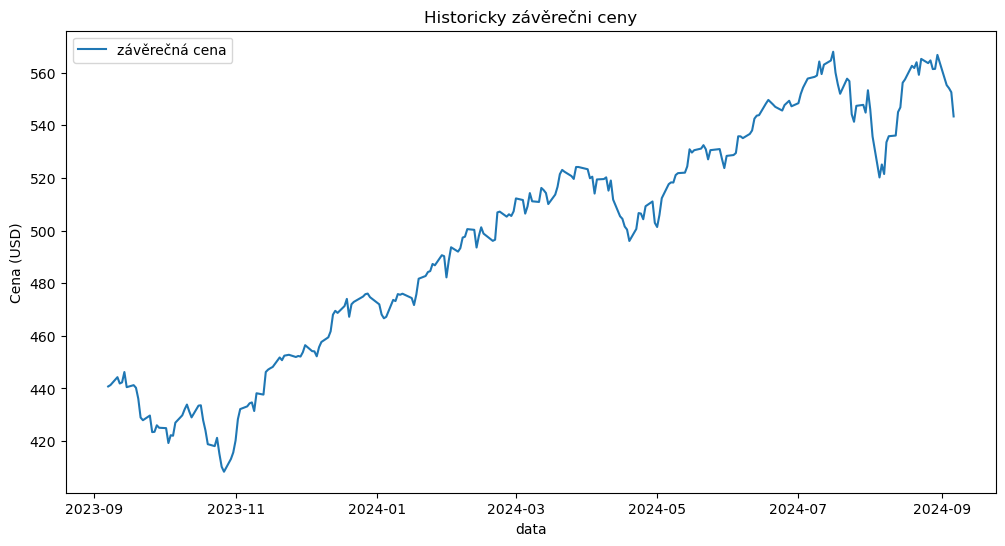

In [11]:
plt.figure(figsize =(12,6))
plt.plot(close_prices.index, close_prices, label='závěrečná cena')
plt.title('Historicky závěrečni ceny')
plt.xlabel('data')
plt.ylabel('Cena (USD)')
plt.legend()
plt.show()

# NAVPS fondu IVV 

In [12]:
t_a = 501_355_359_111 #Celková aktiva
t_l = 0 #Celkové závazky
t_s = 923_250_000 #Celkový počet akcií

##### Vypočet NAVPS pro akce: (Celková aktiva - Celkové závazky : Celkový počet akcií
##### Vypočet NAVPS pro ETF: (Celková aktiva - Celkový počet akcií)

In [36]:
if t_s >0:
    NAVPS = (t_a / t_s)
    print(f"NAVPS fondu: {NAVPS:.2f} USD")
else:
    print('Chyba - počet akcií se rovna 0')

NAVPS fondu: 543.03 USD


# Vypočet modelu CAPM

In [14]:
apple = yf.download('AAPL', start='2014-08-09', end='2024-08-09', progress=False)
sp500 = yf.download('^GSPC', start='2014-08-09', end='2024-08-09', progress=False)
bonds10y = yf.download('^TNX', start='2014-08-09', end='2024-08-09', progress=False)

In [15]:
apple['Returns'] = apple['Adj Close'].pct_change()
sp500['Returns'] = sp500['Adj Close'].pct_change()

In [16]:
apple = apple.dropna()
sp500 = sp500.dropna()

In [17]:
risk_free_rate = bonds10y['Adj Close'].iloc[-1]/100

In [18]:
cov_matrix = np.cov(apple['Returns'], sp500['Returns'])

In [19]:
beta = cov_matrix[0, 1] / cov_matrix[1, 1]

In [20]:
market_return = sp500['Returns'].mean() *252

#### model vypočtu modelů CAPM: Bezriziková sazba + Beta *(nasobit) (tržní výnosnost - Bezriziková sazba

In [21]:
expected_return = risk_free_rate + beta * (market_return - risk_free_rate)

In [22]:
print(f"Beta: {beta:.2f}")
print(f'risk_free_rate: {risk_free_rate:.2%}')
print(f'market_return: {market_return:.2%}')


Beta: 1.20
risk_free_rate: 4.00%
market_return: 11.72%


## CAPM 

In [23]:
print(f"Expected Return (CAPM): {expected_return:.2%}")

Expected Return (CAPM): 13.25%


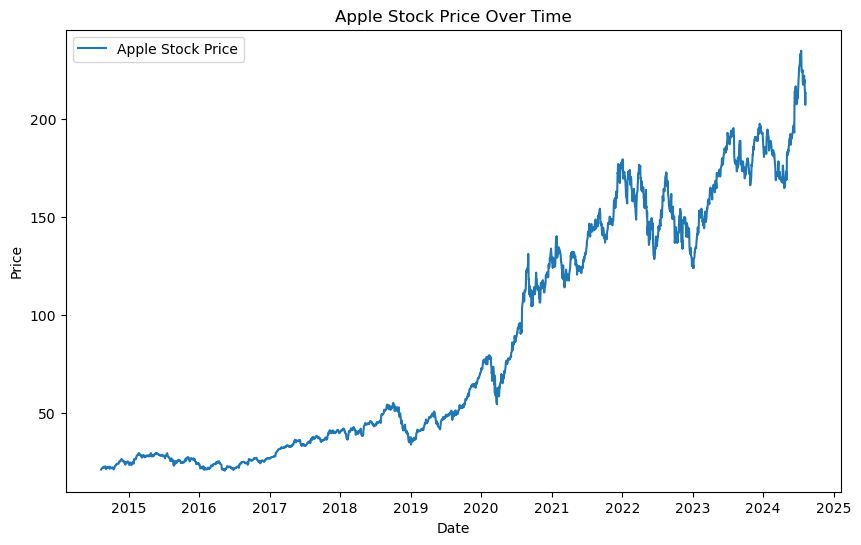

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(apple.index, apple['Adj Close'], label='Apple Stock Price')
plt.title('Apple Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Histiricky CAPM (GRAF)

In [25]:
dates = []
capm_values = []

In [26]:
for date in pd.date_range(start='2014-08-09', end='2024-08-09', freq='ME'):
    # Подвыборка данных до текущей даты
    apple_subset = apple.loc[:date].copy()
    sp500_subset = sp500.loc[:date].copy()
    bonds_subset = bonds10y.loc[:date].copy()
    
    apple_subset['Returns'] = apple_subset['Adj Close'].pct_change()
    sp500_subset['Returns'] = sp500_subset['Adj Close'].pct_change()
    
    apple_subset = apple_subset.dropna()
    sp500_subset = sp500_subset.dropna()
    
    if not apple_subset.empty and not sp500_subset.empty:
        risk_free_rate = bonds_subset['Adj Close'].iloc[-1] / 100
        cov_matrix = np.cov(apple_subset['Returns'], sp500_subset['Returns'])
        market_return = sp500_subset['Returns'].mean() *252
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
        
        dates.append(date)
        capm_values.append(expected_return)

In [27]:
capm_df = pd.DataFrame({'Date': dates, 'CAPM Expected Return': capm_values})
capm_df.set_index('Date', inplace=True)

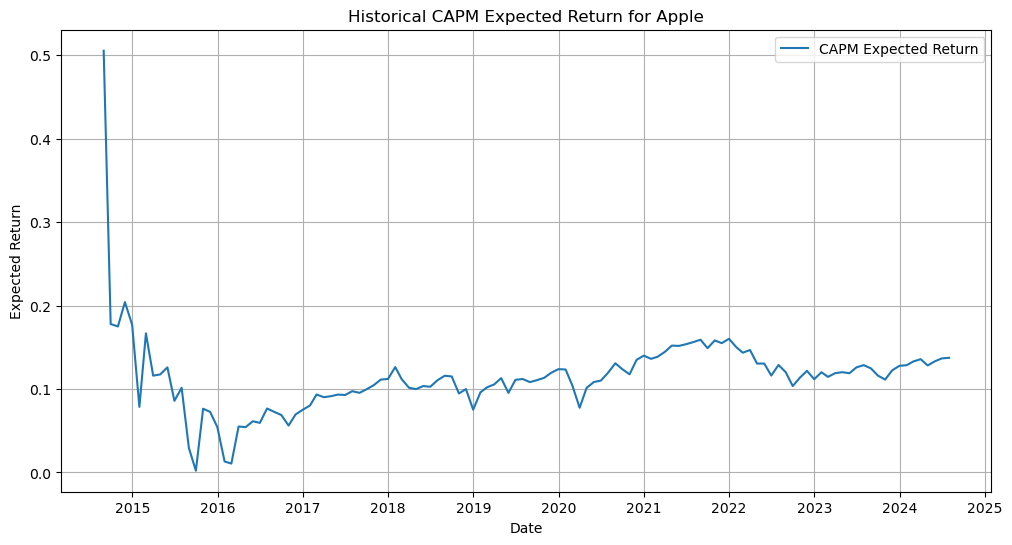

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(capm_df.index, capm_df['CAPM Expected Return'], label='CAPM Expected Return')
plt.title('Historical CAPM Expected Return for Apple')
plt.xlabel('Date')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# Vypočet VAR(Value At Risk) pro Coffee Future (KC=F)

In [29]:
data = yf.download('KC=F', start='2024-05-07', end='2024-09-07', interval='1D')

[*********************100%***********************]  1 of 1 completed


In [30]:
data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1))

In [31]:
log_returns = data['Log Returns'].dropna()

In [32]:
confidence_level = 0.95

In [33]:
var_hist = np.percentile(log_returns, (1 - confidence_level) * 100)

In [34]:
print(f'Historical Var At {confidence_level*100}% confidence level: {var_hist:.4f}')

Historical Var At 95.0% confidence level: -0.0338


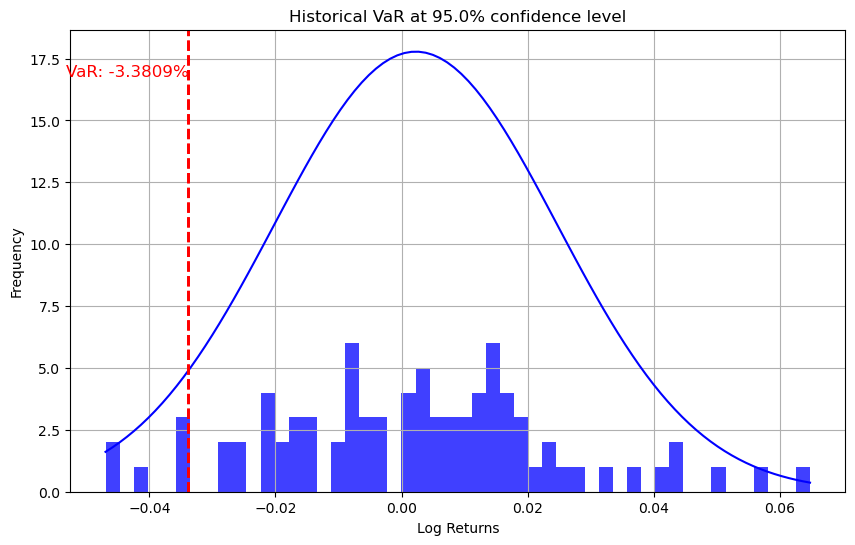

In [35]:
mu, std = norm.fit(log_returns)
xmin, xmax = log_returns.min(), log_returns.max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.figure(figsize=(10, 6))
plt.plot(x, p, 'b-', label='Density')
plt.axvline(x=var_hist, color='red', linestyle='dashed', linewidth=2, label=f'VaR: {var_hist:.4%}')
plt.hist(log_returns, bins=50, alpha=0.75, color='blue')
plt.axvline(x=var_hist, color='red', linestyle='dashed', linewidth=2)
plt.text(var_hist, plt.ylim()[1]*0.9, f'VaR: {var_hist:.4%}', color='red', fontsize=12, ha='right')
plt.grid(True)
plt.title(f'Historical VaR at {confidence_level*100}% confidence level')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()